In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import scipy as sc

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Bayesian estimation

$$
\Pr(p\mid data) = \frac{{n\choose y} p^{y} (1-p)^{n-y}}{\int_0^1 {n\choose y} \pi^y (1-\pi)^{n-y}}
$$

Text(0.5, 0, '$p$')

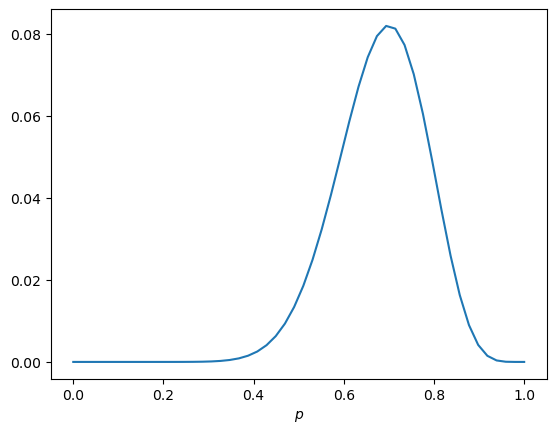

In [4]:
range_p = np.linspace(0,1,50)
prior = np.ones_like(range_p)
likelihood = sc.stats.binom.pmf(14,20, range_p)
posterior = likelihood*prior/np.sum(likelihood*prior)

plt.plot(range_p, posterior)
plt.xlabel('$p$')

In [5]:
def generating_data(
        a1 = 1,
        a2 = -1,
        b = 3,
        n = 100
):
    x1 = pm.Normal.dist(0,1).random(size=n)
    x2 = pm.Normal.dist(0,1).random(size=n)
    noise = pm.Normal.dist(0,1).random(size=n)

    y = a1*x1 + a2*x2 + b + noise
    df = pd.DataFrame(
        {
            'x1': x1,
            'x2': x2,
            'y': y
        }
    )
    return df

df = generating_data()
df.head()

,x1,x2,y
0,0.299406,0.863986,1.052627
1,-0.598155,-0.324268,1.640066
2,-0.009153,-1.842924,4.375372
3,-1.536057,0.246169,0.425521
4,-1.509574,1.406736,-0.863765


## Specify model

In [6]:
with pm.Model() as model_simulated_data:
    constant = pm.Normal('constant', 0, 3)
    slope1 = pm.Normal('slope1', 0, 2)
    slope2 = pm.Normal('slope2', 0, 2)
    sigma = pm.HalfNormal('sigma', 1)
    obs = pm.Normal(
        'obs',
        mu = constant + slope1*df.x1 + slope2*df.x2,
        sigma = sigma,
        observed = df.y
    )
    trace = pm.sample()

C:\Users\chris\AppData\Local\Temp\ipykernel_19648\3629020241.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope2, slope1, constant]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.


In [7]:
with model_simulated_data:
    ppc_simulated_data = pm.sample_posterior_predictive(
        trace,
        var_names = ['obs']
    )

data_posterior_simulated_data = az.from_pymc3(
    trace,
    posterior_predictive = ppc_simulated_data
)

c:\Users\chris\miniconda3\envs\uvt\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


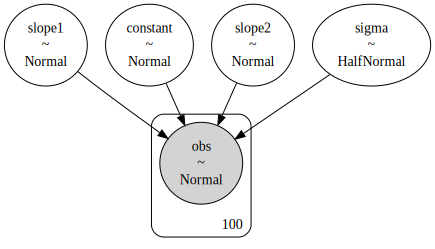

In [8]:
pm.model_to_graphviz(
    model_simulated_data
)

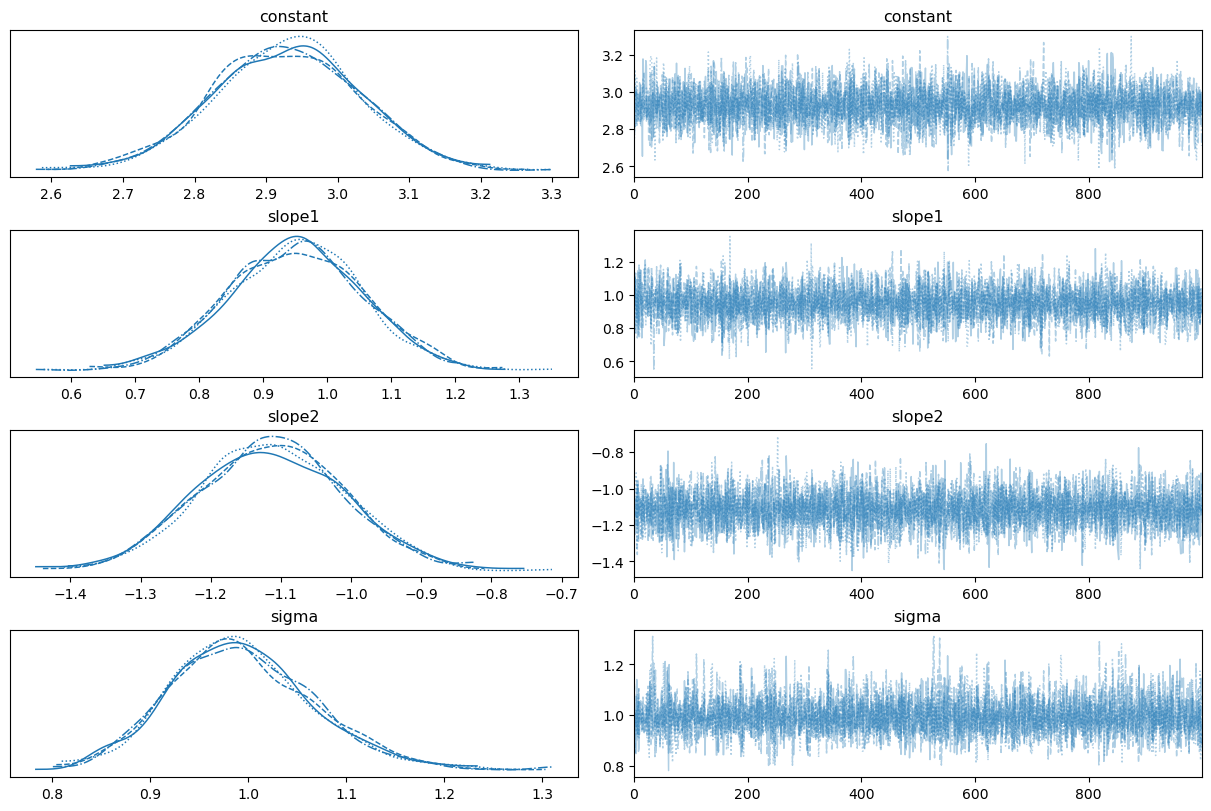

In [9]:
with model_simulated_data:
    pm.plot_trace(trace)

* Right plot must zigzag around a constant mean
* Right plot gives draws from the distribution
* Left plot is a kernel density plot

In [10]:
az.summary(data_posterior_simulated_data.posterior)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
constant,2.929,0.102,2.736,3.117,0.001,0.001,5503.0,2772.0,1.0
slope1,0.950,0.104,0.770,1.158,0.001,0.001,5155.0,3184.0,1.0
slope2,-1.114,0.103,-1.308,-0.925,0.001,0.001,6372.0,3275.0,1.0
sigma,0.994,0.074,0.852,1.129,0.001,0.001,5742.0,2515.0,1.0


With $94\%$ probability, the constant lies between $2.7$ and $3.1$.

If $\hat{R} \neq 1$, something went wrong

In [11]:
data_posterior_simulated_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

Most of the time, use `posterior_predictive` or `posterior`

[Text(0.5, 0, '$x_2$'), Text(0, 0.5, '$y$')]

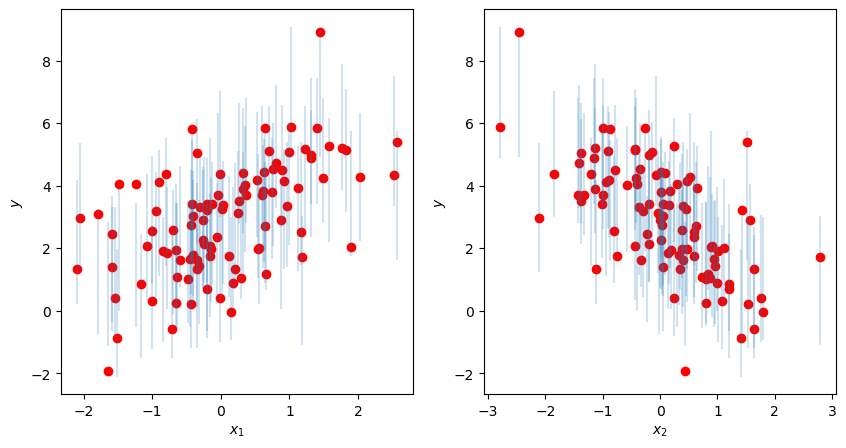

In [15]:
percentiles = np.percentile(
    ppc_simulated_data['obs'],
    [2.5, 97.5],
    axis = 0
).T

fig, (ax1, ax2) = plt.subplots(
    nrows = 1,
    ncols = 2,
    figsize = (10,5)
)

ax1.vlines(df.x1, percentiles[:,0], percentiles[:,1], alpha = 0.2)
ax1.scatter(df.x1, df.y, color = 'r')
ax1.set(xlabel = '$x_1$', ylabel = '$y$')

ax2.vlines(df.x2, percentiles[:,0], percentiles[:,1], alpha = 0.2)
ax2.scatter(df.x2, df.y, color = 'r')
ax2.set(xlabel = '$x_2$', ylabel = '$y$')

We are interested in the percentiles. Red dots are observations, the predictions fall within the blue vertical lines.

# Repeat but with real data

In [2]:
df = pd.read_csv("./data/health_data.csv")
df.head()

,Unnamed: 0,country,year,sex,Preventable mortality,Treatable mortality,GDP per capita,y_QU1,y_QU2,y_QU3,y_QU4,y_QU5,high bmi,smoking,binge drinking
0,0,Austria,2011,F,95.29,67.41,36970.0,16542.1,27955.8,36687.8,48214.5,74519.8,0.113,0.083,0.375
1,1,Austria,2011,M,248.50,96.86,36970.0,16542.1,27955.8,36687.8,48214.5,74519.8,0.146,0.141,0.300
2,2,Austria,2012,F,96.16,69.72,37820.0,16542.1,27955.8,36687.8,48214.5,74519.8,0.113,0.083,0.375
3,3,Austria,2012,M,252.28,91.45,37820.0,16542.1,27955.8,36687.8,48214.5,74519.8,0.146,0.141,0.300
4,4,Austria,2013,F,93.22,66.84,38210.0,16542.1,27955.8,36687.8,48214.5,74519.8,0.113,0.083,0.375


From the gdp-mortality graph plotted earlier, there appears to be a linear relationship between GDP per capita and treatable mortality. If a country is richer, the difference between male/female mortality seems to go down.

In [3]:
df.describe()

,Unnamed: 0,year,Preventable mortality,Treatable mortality,GDP per capita,y_QU1,y_QU2,y_QU3,y_QU4,y_QU5,high bmi,smoking,binge drinking
count,392.000000,392.000000,392.000000,392.000000,392.000000,378.000000,378.000000,378.000000,378.000000,378.000000,392.000000,392.000000,364.000000
mean,195.500000,2014.000000,201.227985,117.503061,26901.632653,9857.303704,16676.592593,23098.081481,31048.800000,50787.992593,0.150536,0.077946,0.279212
std,113.304898,2.002556,137.319180,62.968603,18059.081481,6251.853723,10409.193406,13409.127693,17601.400318,28425.770534,0.035677,0.058545,0.063422
min,0.000000,2011.000000,46.690000,54.630000,5640.000000,1681.500000,3048.300000,4116.600000,5764.500000,9844.500000,0.077000,0.000000,0.158000
25%,97.750000,2012.000000,97.737500,74.757500,13550.000000,4233.300000,7538.900000,10857.300000,14587.300000,26053.400000,0.129000,0.032750,0.229000
50%,195.500000,2014.000000,168.830000,91.855000,21540.000000,8959.400000,15485.100000,22706.800000,31267.900000,51661.800000,0.146500,0.060500,0.278000
75%,293.250000,2016.000000,236.400000,142.205000,37632.500000,15503.800000,24861.300000,33979.600000,45565.700000,72170.400000,0.175000,0.110000,0.309000
max,391.000000,2017.000000,660.160000,333.310000,97440.000000,26230.100000,47129.000000,56621.700000,75137.200000,127617.700000,0.267000,0.250000,0.458000


In [4]:
df_small = df.dropna()
df_small.describe()

,Unnamed: 0,year,Preventable mortality,Treatable mortality,GDP per capita,y_QU1,y_QU2,y_QU3,y_QU4,y_QU5,high bmi,smoking,binge drinking
count,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000
mean,194.660000,2014.000000,209.579886,123.292371,26108.228571,9282.928000,15977.464000,22237.380000,29964.860000,48943.696000,0.154960,0.080660,0.281300
std,118.242509,2.002863,141.639764,64.214638,18868.361650,6129.141978,10502.900759,13572.013047,17853.560941,28750.245699,0.034657,0.060855,0.063793
min,0.000000,2011.000000,46.690000,54.630000,5640.000000,1681.500000,3048.300000,4116.600000,5764.500000,9844.500000,0.077000,0.000000,0.158000
25%,87.250000,2012.000000,100.592500,78.147500,12620.000000,4233.300000,7538.900000,10857.300000,14587.300000,26053.400000,0.131000,0.032000,0.237000
50%,188.500000,2014.000000,172.860000,98.335000,18310.000000,7877.500000,14305.400000,20553.200000,26351.400000,39314.200000,0.151500,0.065000,0.279500
75%,303.750000,2016.000000,245.147500,150.375000,37430.000000,14078.100000,24141.600000,33248.200000,45565.700000,71973.800000,0.178000,0.113000,0.318000
max,391.000000,2017.000000,660.160000,333.310000,97440.000000,26230.100000,47129.000000,56621.700000,75137.200000,127617.700000,0.267000,0.250000,0.458000


In [5]:
def standardise(x):
    return (x-x.mean())/x.std()

log_mortality = standardise(np.log(df_small['Treatable mortality']))
gdp = standardise(np.log(df_small['GDP per capita']))
high_bmi = standardise(df_small['high bmi']) # No need for logs since it is a fraction
smoking = standardise(df_small['smoking'])
binge_drinking = standardise(df_small['binge drinking'])
gender = df_small['sex'] == 'F'

In [7]:
with pm.Model() as normal:
    ## priors on coefficients
    constant = pm.Normal('constant', 0, 1) # should be random variable with mean 0, sd 1 (since we have standardised all variables)
    s_prior = 0.1
    
    b_gdp = pm.Normal('b_gdp', 0, s_prior) # We initially force this variable to 0 with small SD, unless there is very clear evidence in the data that it is not equal to 0
    b_high_bmi = pm.Normal('b_high_bmi', 0, s_prior)
    b_smoking = pm.Normal('b_smoking', 0, s_prior)
    b_binge_drinking = pm.Normal('b_binge_drinking', 0, s_prior)
    b_female = pm.Normal('b_female', 0, s_prior)
    b_gdp_female = pm.Normal('b_gdp_female', 0, s_prior)

    ## specify model
    muu = constant + b_female*gender + b_gdp*gdp + b_smoking*smoking +\
        b_high_bmi*high_bmi + b_binge_drinking*binge_drinking +\
        b_gdp_female*gender*gdp
    
    sig = pm.HalfNormal('sig', 1)
    mortality = pm.Normal('mortality', muu, sig, observed = log_mortality)
    trace_normal = pm.sample(2000, tune=1000)

C:\Users\chris\AppData\Local\Temp\ipykernel_5960\201477091.py:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_normal = pm.sample(2000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig, b_gdp_female, b_female, b_binge_drinking, b_smoking, b_high_bmi, b_gdp, constant]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.


In [8]:
with normal:
    ppc_normal = pm.sample_posterior_predictive(
        trace = trace_normal,
        var_names = ['mortality']
    )

In [10]:
data_posterior_normal = az.from_pymc3(
    trace = trace_normal,
    posterior_predictive = ppc_normal
)

c:\Users\chris\miniconda3\envs\uvt\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


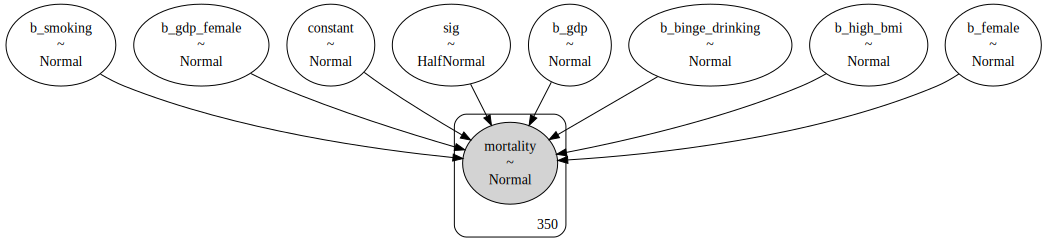

In [11]:
pm.model_to_graphviz(normal)

In [13]:
variables_health = [
    'b_smoking',
    'b_high_bmi',
    'b_binge_drinking'
]

az.summary(
    data_posterior_normal.posterior,
    var_names = variables_health
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_smoking,-0.022,0.035,-0.089,0.043,0.0,0.0,5123.0,5240.0,1.0
b_high_bmi,0.031,0.025,-0.016,0.078,0.0,0.0,9229.0,6198.0,1.0
b_binge_drinking,0.256,0.025,0.209,0.303,0.0,0.0,8473.0,6149.0,1.0


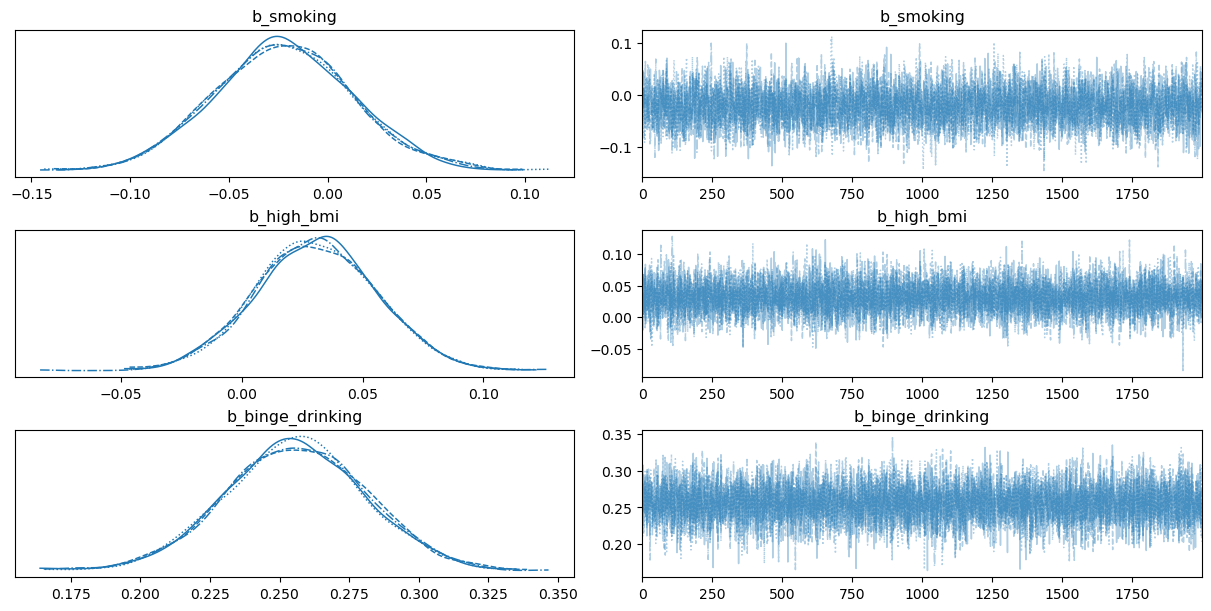

In [15]:
with normal:
    az.plot_trace(
        data = trace_normal,
        var_names = variables_health
    )

Suppose that:

* Benefit of reducing mortality with $1$ standard deviation equals $1,000,000$
* Cost of reducing high BMI with $1$ standard deviation equals $60,000$

Would this policy be worth it?

In [16]:
net_result = (1_000_000 * data_posterior_normal.posterior['b_high_bmi'] - 60_000).values

In [17]:
# Effect from OLS results
net_result.mean()

-29081.922245075668

In [18]:
np.mean(net_result > 0)

0.12525

## Plotting

AttributeError: '_process_plot_var_args' object has no attribute 'prop_cycler'

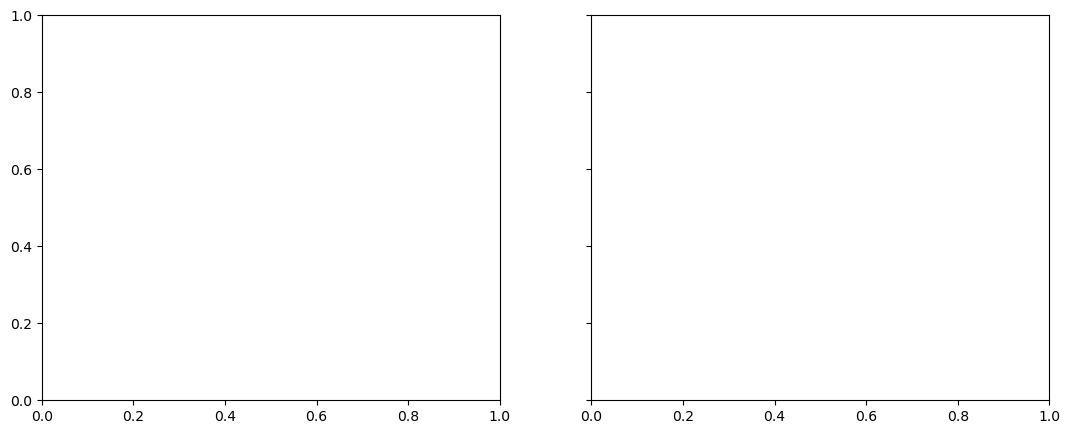

In [26]:
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.cm as mplcm

mask_female = (df_small.sex=='F')
mask_male = (df_small.sex=='M')
percentiles = np.percentile(data_posterior_normal.posterior_predictive.mortality,\
               [2.5,97.5],axis=[0,1])

plt.style.use('seaborn-v0_8-dark-palette')
NUM_COLORS = 24

cm = plt.get_cmap('tab20b') 
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=([scalarMap.to_rgba(i)\
                                for i in range(NUM_COLORS)]))
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True,figsize=(13,5))

for country in df_small.country.unique():
    mask = (df_small.country == country)
    ax1.vlines(gdp[mask_female&mask],percentiles[0,:][mask_female&mask],percentiles[1,:]\
           [mask_female&mask], color = next(ax1._get_lines.prop_cycler)['color'],alpha=0.3)
    ax1.scatter(gdp[mask&(df_small.sex=='F')], log_mortality[mask&(df_small.sex=='F')],\
           label = country)
    ax2.vlines(gdp[mask_male&mask],percentiles[0,:][mask_male&mask],percentiles[1,:]\
           [mask_male&mask], color = next(ax2._get_lines.prop_cycler)['color'],alpha=0.3)
    ax2.scatter(gdp[mask&(df_small.sex=='M')], log_mortality[mask&(df_small.sex=='M')],\
           label = country)
    
ax1.set_xlabel('Log GDP per capita (standardized)')
ax2.set_xlabel('Log GDP per capita (standardized)')
ax1.set_ylabel('Log treatable mortality (standardized)')
ax1.set_title('Female')
ax2.set_title('Male')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);



# Masked arrays

In [21]:
x = np.ma.array(
    [1,2,np.nan],
    mask = [0,0,1]
)
x

masked_array(data=[1.0, 2.0, --],
             mask=[False, False,  True],
       fill_value=1e+20)

`mask=false` means there is no missing data, `=true` means the opposite

In [22]:
x.compressed()

array([1., 2.])

## back to the model

We now add `Gdp` to the model to substitute for missing values. It is taken into account.

In [ ]:
with pm.Model() as normal:
    ## priors on coefficients
    constant = pm.Normal('constant', 0, 1) # should be random variable with mean 0, sd 1 (since we have standardised all variables)
    s_prior = 0.1
    
    b_gdp = pm.Normal('b_gdp', 0, s_prior) # We initially force this variable to 0 with small SD, unless there is very clear evidence in the data that it is not equal to 0
    b_high_bmi = pm.Normal('b_high_bmi', 0, s_prior)
    b_smoking = pm.Normal('b_smoking', 0, s_prior)
    b_binge_drinking = pm.Normal('b_binge_drinking', 0, s_prior)
    b_female = pm.Normal('b_female', 0, s_prior)
    b_gdp_female = pm.Normal('b_gdp_female', 0, s_prior)

    ## missing values
    Gdp = pm.normal('Gdp', mu = 0, sd = 1.0, observed = gdp)

    ## specify model
    muu = constant + b_female*gender + b_gdp*Gdp + b_smoking*smoking +\
        b_high_bmi*high_bmi + b_binge_drinking*binge_drinking +\
        b_gdp_female*gender*Gdp
    
    sig = pm.HalfNormal('sig', 1)
    mortality = pm.Normal('mortality', muu, sig, observed = log_mortality)
    trace_normal = pm.sample(2000, tune=1000)

C:\Users\chris\AppData\Local\Temp\ipykernel_5960\201477091.py:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_normal = pm.sample(2000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig, b_gdp_female, b_female, b_binge_drinking, b_smoking, b_high_bmi, b_gdp, constant]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.


In [23]:
# New standardisation function taking NAs into account
def standardsise_ma(x):
    x_ma = np.ma.masked_invalid(x)
    return (x_ma - x_ma.mean())/x_ma.std()

In [ ]:
log_mortality_ma = standardise_ma(np.log(df['Treatable mortality']))
gdp_ma = standardise_ma(np.log(df['GDP per capita']))
high_bmi_ma = standardise_ma(df['high bmi']) # No need for logs since it is a fraction
smoking_ma = standardise_ma(df['smoking'])
binge_drinking_ma = standardise_ma(df['binge drinking'])
gender_ma = df['sex'] == 'F'

# Confidence intervals

In [24]:
def interval_95(X, sig):
    mean = X.mean(axis=1)
    sig_m = sig/np.sqrt(X.shape[1])
    return np.array([mean - 2*sig_m,
                     mean+2*sig_m])
muu = 100
sig = 10
repetitions = 100_000
n_sample = 9

X = np.random.normal(muu, sig, size = (repetitions, n_sample))

In [25]:
intervals = interval_95(X, sig)
test = (intervals[0] < muu) & (muu < intervals[1])

np.mean(test)

0.954